# Medical Appointment No Shows
Why do 30% of patients miss their scheduled appointments?

https://www.kaggle.com/joniarroba/noshowappointments#

**Author: Małgorzata Stolarska && Magdalena Cebula && Magdalena Pychtjarow**

## Data Dictionary <a class="anchor" id="data_dictionary"></a>
- **PatientId**: Identification of a patient
- **AppointmentID**: Identification of each appointment
- **Gender**: 
Male or Female (female is the greater proportion, woman takes way more care of they health in comparison to man).
- **ScheduledDay**: 
The day of the actuall appointment, when they have to visit the doctor.
- **AppointmentDay**: 
The day someone called or registered the appointment, this is before appointment of course.
- **Age**: 
How old is the patient.
- **Neighbourhood**: 
Where the appointment takes place.
- **Scholarship**: True of False 
- **Hipertension**: True or False
- **Diabetes**: True or False
- **Alcoholism**: True or False
- **Handcap**: Number of disabilities (0 = a person without disability, 1 and more = a person with disabilities)
- **SMS_received**: Messages sent to the patient.
- **No-show (target variable)**: True or False.

## Imports, parameters and initializations <a class="anchor" id="imports"></a>

In [1]:
!python --version

Python 3.7.11


In [2]:
 pip install scikit-learn==0.22.1

  Using cached scikit_learn-0.22.1-cp37-cp37m-manylinux1_x86_64.whl (7.0 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.2
    Uninstalling scikit-learn-0.24.2:
      Successfully uninstalled scikit-learn-0.24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
imbalanced-learn 0.8.0 requires scikit-learn>=0.24, but you have scikit-learn 0.22.1 which is incompatible.


In [3]:
!pip install -U imbalanced-learn

  Using cached scikit_learn-0.24.2-cp37-cp37m-manylinux2010_x86_64.whl (22.3 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.22.1
    Uninstalling scikit-learn-0.22.1:
      Successfully uninstalled scikit-learn-0.22.1


In [4]:
!scikit-learn --version

/bin/bash: scikit-learn: command not found


In [5]:
!pip install --upgrade neptune-client 

In [6]:
!pip install category_encoders

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import sklearn
from sklearn import __version__ as sklearn_version
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, make_scorer, f1_score, precision_score, recall_score
from sklearn.metrics import f1_score, accuracy_score, roc_curve, roc_auc_score, confusion_matrix, plot_confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from keras import metrics
from datetime import time, date, datetime, timezone, timedelta
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTENC 

# freeze randomness:
from numpy.random import seed
from tensorflow.random import set_seed
seed(12) 
set_seed(123)

In [8]:
import neptune

API_TOKEN='' #@param {type:"string"}

PROJEKT_NAME = 'DataWorkshop-Foundation/Predicting-cancellation-of-visit' 

neptune.init(
   api_token=API_TOKEN,
   project_qualified_name=PROJEKT_NAME
)

Project(DataWorkshop-Foundation/Predicting-cancellation-of-visit)

In [9]:
# Pandas options
pd.set_option('display.float_format', '{:.4f}'.format) 
pd.set_option('display.max_columns', None) 
pd.set_option("max_colwidth", None)

# Sklearn options 
from sklearn import set_config
set_config(display='diagram') # interactive diagrams for pipelines

In [10]:
print("pandas:", pd.__version__)
print("numpy:", np.__version__)
print("sklearn:", sklearn_version)

pandas: 1.1.5
numpy: 1.19.5
sklearn: 0.24.2


In [11]:
path = "/content/drive/MyDrive/Colab Notebooks/Cancellation/data/EDA3"
author = "Magdalena Cebula & Magda Pychjarow"

## Data loading and initial checks <a class="anchor" id="loading"></a>

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
df = pd.read_csv(r'/content/drive/MyDrive/Colab Notebooks/Cancellation/data/KaggleV2-May-2016.csv')
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,29872499824296.0000,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,558997776694438.0000,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4262962299951.0000,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,867951213174.0000,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8841186448183.0000,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [14]:
df.shape

(110527, 14)

In [15]:
# Check duplicates
df.duplicated().sum()

0

In [16]:
# Check types
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   PatientId       110527 non-null  float64
 1   AppointmentID   110527 non-null  int64  
 2   Gender          110527 non-null  object 
 3   ScheduledDay    110527 non-null  object 
 4   AppointmentDay  110527 non-null  object 
 5   Age             110527 non-null  int64  
 6   Neighbourhood   110527 non-null  object 
 7   Scholarship     110527 non-null  int64  
 8   Hipertension    110527 non-null  int64  
 9   Diabetes        110527 non-null  int64  
 10  Alcoholism      110527 non-null  int64  
 11  Handcap         110527 non-null  int64  
 12  SMS_received    110527 non-null  int64  
 13  No-show         110527 non-null  object 
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


In [17]:
# Check target (ratio)
df["No-show"].value_counts(normalize=True, dropna=False)

No    0.7981
Yes   0.2019
Name: No-show, dtype: float64

## Initial preprocessing <a class="anchor" id="preprocessing"></a>

Assuming that the solution would be deployed in a production environment, I would be able to obtain data about the patient's history, such as the number of previous visits and the number of missed visits. I prepare such data below, i.e. for each appointment, I count data of previous appointments of the same patient.

The data don't include the time of appointments. In the case of a production solution, it should be added, but here I assume that sorting by AppointmentDay returns appointments in the correct orders.

In [18]:
def medicalAppointmentsDataPrepare(df, days_to_count=28):
    """
    Preparing Medical Appointments data
    """
    df_copy = df.copy()
  

    # Change types
    df_copy = df_copy.astype(dtype={"PatientId":"int64", \
                                    "ScheduledDay":"datetime64", \
                                    "AppointmentDay":"datetime64"})      
    
    # Change Yes/No to 1/0
    if set(df["No-show"].unique()) == {'No', 'Yes'}:
        df_copy["No-show"] = df_copy["No-show"].map({"Yes":1, "No":0}, na_action='ignore').astype("int64")  
    
    window = "".join([str(days_to_count), "D"])
    print("Window:", window)
     
    for idxs in df_copy.sort_values("AppointmentDay").groupby("PatientId").groups.values():          
        # Last successful visit and number of canceled visits since a last successful visit
        last_show = pd.Timestamp(0)
        last_noshow = pd.Timestamp(0)
        sumRecentNoShows = 0
        for i in idxs:
            df_copy.loc[i,"_lastShow"] = last_show
            df_copy.loc[i,"_lastNoShow"] = last_noshow
            df_copy.loc[i,"_sumRecentNoShows"] = sumRecentNoShows
            # the current visit cannot be included in the sum set for the current visit:
            if df_copy.loc[i,"No-show"] == 0:
                last_show = df_copy.loc[i,"AppointmentDay"]
                sumRecentNoShows = 0
            else:
                last_noshow = df_copy.loc[i,"AppointmentDay"]
                sumRecentNoShows += 1    

        # Number of canceled visits for a given patient in the last "days_to_count" days (without the current visit)
        rolled = df_copy.loc[idxs].rolling(window=window, on="AppointmentDay", min_periods=1, center=False, closed="left")
        df_copy.loc[idxs,"_sumAppoint_xD"] = rolled["No-show"].count().fillna(0)
        df_copy.loc[idxs,"_sumNoShows_xD"] = rolled["No-show"].sum().fillna(0)
    
    return df_copy   # .loc[days_to_count:] # we have no full data for the first "days_to_count" days

In [19]:
df = medicalAppointmentsDataPrepare(df)


Window: 28D


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 19 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   PatientId          110527 non-null  int64         
 1   AppointmentID      110527 non-null  int64         
 2   Gender             110527 non-null  object        
 3   ScheduledDay       110527 non-null  datetime64[ns]
 4   AppointmentDay     110527 non-null  datetime64[ns]
 5   Age                110527 non-null  int64         
 6   Neighbourhood      110527 non-null  object        
 7   Scholarship        110527 non-null  int64         
 8   Hipertension       110527 non-null  int64         
 9   Diabetes           110527 non-null  int64         
 10  Alcoholism         110527 non-null  int64         
 11  Handcap            110527 non-null  int64         
 12  SMS_received       110527 non-null  int64         
 13  No-show            110527 non-null  int64   

In [21]:
df[df["_sumNoShows_xD"]>0].sort_values("_sumNoShows_xD", ascending=False).head(100).tail(5)

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,_lastShow,_lastNoShow,_sumRecentNoShows,_sumAppoint_xD,_sumNoShows_xD
59655,476861615941,5636095,F,2016-04-28 14:29:54,2016-05-20,43,SANTO ANDRÉ,1,0,0,0,0,0,1,2016-05-11,2016-05-20,1.0000,8.0000,7.0000
95217,216298164113,5769468,M,2016-06-03 08:51:28,2016-06-03,17,CARATOÍRA,0,0,0,0,0,0,1,1970-01-01,2016-05-31,7.0000,7.0000,7.0000
95216,9995994929266,5769469,M,2016-06-03 08:51:28,2016-06-03,17,SANTA TEREZA,0,0,0,0,0,0,1,2016-05-13,2016-05-20,4.0000,8.0000,7.0000
55905,2728422248149,5635984,F,2016-04-28 14:22:23,2016-05-20,44,SÃO JOSÉ,0,0,0,0,0,0,1,2016-05-18,2016-05-20,2.0000,11.0000,7.0000
53392,1198157171975,5683706,M,2016-05-11 07:47:24,2016-05-11,10,NOVA PALESTINA,1,0,0,0,0,0,1,2016-05-10,2016-05-11,2.0000,10.0000,7.0000


In [22]:
df[df["PatientId"]==2728422248149]\
         [["AppointmentDay","No-show","_lastShow","_lastNoShow","_sumRecentNoShows","_sumAppoint_xD","_sumNoShows_xD"]]\
         .sort_values("AppointmentDay")

,AppointmentDay,No-show,_lastShow,_lastNoShow,_sumRecentNoShows,_sumAppoint_xD,_sumNoShows_xD
55896,2016-05-02,1,1970-01-01,1970-01-01,0.0000,0.0000,0.0000
44617,2016-05-03,0,1970-01-01,2016-05-02,1.0000,1.0000,1.0000
25845,2016-05-06,1,2016-05-03,2016-05-02,0.0000,2.0000,1.0000
55927,2016-05-06,1,2016-05-03,2016-05-06,1.0000,3.0000,2.0000
59642,2016-05-06,1,2016-05-03,2016-05-06,2.0000,4.0000,3.0000
55744,2016-05-09,1,2016-05-03,2016-05-06,3.0000,5.0000,4.0000
71706,2016-05-12,0,2016-05-03,2016-05-09,4.0000,6.0000,5.0000
70983,2016-05-16,0,2016-05-12,2016-05-09,0.0000,7.0000,5.0000
29563,2016-05-18,0,2016-05-16,2016-05-09,0.0000,8.0000,5.0000
25831,2016-05-20,1,2016-05-18,2016-05-09,0.0000,9.0000,5.0000


#### [Save data]

In [23]:
# Dump data to pickle
with open("/".join([path, "prepared_NoShows.obj"]), "wb") as fp:
    pickle.dump(df, fp)

In [24]:
# Read data from pickle 
with open("/".join([path, "prepared_NoShows.obj"]), 'rb') as fp:
    df = pickle.load(fp)

## Split data set into training, validation and test parts <a class="anchor" id="split"></a>

In [25]:
# First, split patients:

# Choose unique patients
patients = pd.DataFrame(df["PatientId"].unique(), columns=["PatientId"])

# Split patients into training and test subsets
p_train, p_test = train_test_split(patients, test_size=0.3, random_state=33)

# Split patients from the test data into validation and test subsets
p_valid, p_test = train_test_split(p_test, test_size=0.5, random_state=33)

In [26]:
p_train.shape

(43609, 1)

In [27]:
p_test.shape

(9345, 1)

In [28]:
p_valid.shape

(9345, 1)

In [29]:
p_train

,PatientId
9962,874329628159
50399,763993274755126
52586,43554754194254
51020,925554543815192
47101,4579645181793
...,...
27282,264252846812568
578,2231147746728
38616,96847214711
2439,235825352744898


In [30]:
X_train = df.merge(p_train, on="PatientId", how="inner")
X_train

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,_lastShow,_lastNoShow,_sumRecentNoShows,_sumAppoint_xD,_sumNoShows_xD
0,29872499824296,5642903,F,2016-04-29 18:38:08,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0,0,1970-01-01,1970-01-01,0.0000,0.0000,0.0000
1,29872499824296,5639907,F,2016-04-29 09:47:47,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0,0,2016-04-29,1970-01-01,0.0000,1.0000,0.0000
2,558997776694438,5642503,M,2016-04-29 16:08:27,2016-04-29,56,JARDIM DA PENHA,0,0,0,0,0,0,0,2016-04-29,1970-01-01,0.0000,1.0000,0.0000
3,558997776694438,5642211,M,2016-04-29 15:20:47,2016-04-29,56,JARDIM DA PENHA,0,0,0,0,0,0,0,1970-01-01,1970-01-01,0.0000,0.0000,0.0000
4,867951213174,5642828,F,2016-04-29 17:29:31,2016-04-29,8,PONTAL DE CAMBURI,0,0,0,0,0,0,0,1970-01-01,1970-01-01,0.0000,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77207,171213473862,5788054,M,2016-06-08 11:06:40,2016-06-08,21,MARIA ORTIZ,0,0,0,0,0,0,0,1970-01-01,1970-01-01,0.0000,0.0000,0.0000
77208,7499488949126,5759838,M,2016-06-01 13:49:47,2016-06-01,40,MARIA ORTIZ,0,0,0,0,0,0,0,1970-01-01,1970-01-01,0.0000,0.0000,0.0000
77209,823599626588,5786742,F,2016-06-08 08:50:20,2016-06-08,14,MARIA ORTIZ,0,0,0,0,0,0,0,1970-01-01,1970-01-01,0.0000,0.0000,0.0000
77210,72633149253362,5630375,F,2016-04-27 15:15:06,2016-06-07,50,MARIA ORTIZ,0,0,0,0,0,1,0,1970-01-01,1970-01-01,0.0000,0.0000,0.0000


In [31]:
# Create training data
#X_train = df.merge(p_train, on="PatientId", how="inner")
y_train = X_train["No-show"]
X_train.drop(columns="No-show", inplace=True)

In [32]:
# Create validation data
X_valid = df.merge(p_valid, on="PatientId", how="inner")
y_valid = X_valid["No-show"]
X_valid.drop(columns="No-show", inplace=True)

In [33]:
# Create test data
X_test = df.merge(p_test, on="PatientId", how="inner")
y_test = X_test["No-show"]
X_test.drop(columns="No-show", inplace=True)

In [34]:
# Shape od data sets
print("Training set:", X_train.shape, y_train.shape)
print("Validation set:", X_valid.shape, y_valid.shape)
print("Test set:", X_test.shape, y_test.shape)

Training set: (77212, 18) (77212,)
Validation set: (16536, 18) (16536,)
Test set: (16779, 18) (16779,)


In [35]:
y_train.value_counts(normalize=True, dropna=False)

0   0.7977
1   0.2023
Name: No-show, dtype: float64

In [36]:
y_valid.value_counts(normalize=True, dropna=False)

0   0.8006
1   0.1994
Name: No-show, dtype: float64

In [37]:
y_test.value_counts(normalize=True, dropna=False)

0   0.7971
1   0.2029
Name: No-show, dtype: float64

In [38]:
y_train.value_counts(normalize=True, dropna=False)[1]/y_train.value_counts(normalize=True, dropna=False)[0]

0.25354330708661416

In [39]:
y_valid.value_counts(normalize=True, dropna=False)[1]/y_valid.value_counts(normalize=True, dropna=False)[0]

0.2490369363244958

In [40]:
y_test.value_counts(normalize=True, dropna=False)[1]/y_test.value_counts(normalize=True, dropna=False)[0]

0.25459847465231045

## Data review on the training set <a class="anchor" id="data_review"></a>

In [41]:
X_train.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,_lastShow,_lastNoShow,_sumRecentNoShows,_sumAppoint_xD,_sumNoShows_xD
0,29872499824296,5642903,F,2016-04-29 18:38:08,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0,1970-01-01,1970-01-01,0.0000,0.0000,0.0000
1,29872499824296,5639907,F,2016-04-29 09:47:47,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0,2016-04-29,1970-01-01,0.0000,1.0000,0.0000
2,558997776694438,5642503,M,2016-04-29 16:08:27,2016-04-29,56,JARDIM DA PENHA,0,0,0,0,0,0,2016-04-29,1970-01-01,0.0000,1.0000,0.0000
3,558997776694438,5642211,M,2016-04-29 15:20:47,2016-04-29,56,JARDIM DA PENHA,0,0,0,0,0,0,1970-01-01,1970-01-01,0.0000,0.0000,0.0000
4,867951213174,5642828,F,2016-04-29 17:29:31,2016-04-29,8,PONTAL DE CAMBURI,0,0,0,0,0,0,1970-01-01,1970-01-01,0.0000,0.0000,0.0000


In [42]:
X_train.describe()

,PatientId,AppointmentID,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,_sumRecentNoShows,_sumAppoint_xD,_sumNoShows_xD
count,77212.0000,77212.0000,77212.0000,77212.0000,77212.0000,77212.0000,77212.0000,77212.0000,77212.0000,77212.0000,77212.0000,77212.0000
mean,146220554410208.2500,5675023.3771,37.1897,0.0959,0.1969,0.0714,0.0304,0.0230,0.3224,0.1146,1.1298,0.1887
std,254682375184094.2812,71629.5382,23.1154,0.2945,0.3977,0.2575,0.1718,0.1627,0.4674,0.4477,3.3304,0.6084
min,43741.0000,5122866.0000,-1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
25%,4155717965492.2500,5640068.5000,18.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
50%,31898380549723.0000,5680408.0000,37.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
75%,94282577557931.0000,5725450.2500,56.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,1.0000,0.0000
max,999981631772427.0000,5790484.0000,115.0000,1.0000,1.0000,1.0000,1.0000,4.0000,1.0000,17.0000,66.0000,14.0000


In [43]:
X_train.isna().any()

PatientId            False
AppointmentID        False
Gender               False
ScheduledDay         False
AppointmentDay       False
Age                  False
Neighbourhood        False
Scholarship          False
Hipertension         False
Diabetes             False
Alcoholism           False
Handcap              False
SMS_received         False
_lastShow            False
_lastNoShow          False
_sumRecentNoShows    False
_sumAppoint_xD       False
_sumNoShows_xD       False
dtype: bool

In [44]:
# Columns with NaN
with pd.option_context("display.max_rows", X_train.shape[1]):
    print(X_train.isna().any()[X_train.isna().any()])
    
# No NaNs in data

Series([], dtype: bool)


In [45]:
# Counted values in columns
for col in X_train.columns[2:]:
    print("Column:", col)
    with pd.option_context("display.max_rows", 20):
        print(X_train[col].value_counts(dropna=False))
    print("-" * 30)

Column: Gender
F    50152
M    27060
Name: Gender, dtype: int64
------------------------------
Column: ScheduledDay
2016-05-06 07:09:53    17
2016-05-06 07:09:54    17
2016-04-25 17:18:27    15
2016-04-25 17:17:46    15
2016-04-25 17:17:23    13
                       ..
2016-05-03 07:31:23     1
2016-04-27 11:01:40     1
2016-05-11 07:19:00     1
2016-03-23 10:29:56     1
2016-06-01 08:23:14     1
Name: ScheduledDay, Length: 73341, dtype: int64
------------------------------
Column: AppointmentDay
2016-06-06    3318
2016-05-30    3202
2016-05-09    3189
2016-05-16    3176
2016-05-11    3135
              ... 
2016-05-25    2741
2016-05-06    2671
2016-05-20    2665
2016-04-29    2280
2016-05-14      26
Name: AppointmentDay, Length: 27, dtype: int64
------------------------------
Column: Age
 0      2423
 1      1598
 52     1286
 38     1201
 56     1196
        ... 
 100       3
 102       2
 98        2
 115       1
-1         1
Name: Age, Length: 103, dtype: int64
-----------------

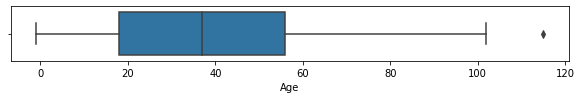

In [46]:
plt.figure(figsize=(10,1))
ax = sns.boxplot(x=X_train["Age"])
plt.show()

## Data transformation <a class="anchor" id="data_transformation"></a>

In [47]:
df_ratio_noshow_location = df.copy()

In [48]:
df_ratio_noshow_location

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,_lastShow,_lastNoShow,_sumRecentNoShows,_sumAppoint_xD,_sumNoShows_xD
0,29872499824296,5642903,F,2016-04-29 18:38:08,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0,0,1970-01-01,1970-01-01,0.0000,0.0000,0.0000
1,558997776694438,5642503,M,2016-04-29 16:08:27,2016-04-29,56,JARDIM DA PENHA,0,0,0,0,0,0,0,2016-04-29,1970-01-01,0.0000,1.0000,0.0000
2,4262962299951,5642549,F,2016-04-29 16:19:04,2016-04-29,62,MATA DA PRAIA,0,0,0,0,0,0,0,1970-01-01,1970-01-01,0.0000,0.0000,0.0000
3,867951213174,5642828,F,2016-04-29 17:29:31,2016-04-29,8,PONTAL DE CAMBURI,0,0,0,0,0,0,0,1970-01-01,1970-01-01,0.0000,0.0000,0.0000
4,8841186448183,5642494,F,2016-04-29 16:07:23,2016-04-29,56,JARDIM DA PENHA,0,1,1,0,0,0,0,1970-01-01,1970-01-01,0.0000,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110522,2572134369293,5651768,F,2016-05-03 09:15:35,2016-06-07,56,MARIA ORTIZ,0,0,0,0,0,1,0,1970-01-01,2016-05-16,1.0000,1.0000,1.0000
110523,3596266328735,5650093,F,2016-05-03 07:27:33,2016-06-07,51,MARIA ORTIZ,0,0,0,0,0,1,0,2016-06-03,2016-05-02,0.0000,1.0000,0.0000
110524,15576631729893,5630692,F,2016-04-27 16:03:52,2016-06-07,21,MARIA ORTIZ,0,0,0,0,0,1,0,1970-01-01,1970-01-01,0.0000,0.0000,0.0000
110525,92134931435557,5630323,F,2016-04-27 15:09:23,2016-06-07,38,MARIA ORTIZ,0,0,0,0,0,1,0,2016-05-05,1970-01-01,0.0000,0.0000,0.0000


In [49]:
noshow_loc_sum = (df_ratio_noshow_location.groupby('Neighbourhood')['No-show'].sum()/df_ratio_noshow_location.groupby('Neighbourhood')['No-show'].count()).reset_index().rename(columns={'No-show': 'NoShowLocationTotalSum',})

In [50]:
noshow_loc_sum.sort_values(by = 'NoShowLocationTotalSum')

,Neighbourhood,NoShowLocationTotalSum
51,PARQUE INDUSTRIAL,0.0000
31,ILHA DO BOI,0.0857
0,AEROPORTO,0.1250
48,MÁRIO CYPRESTE,0.1456
73,SOLON BORGES,0.1471
...,...,...
36,ITARARÉ,0.2627
62,SANTA CLARA,0.2648
61,SANTA CECÍLIA,0.2746
70,SANTOS DUMONT,0.2892


In [51]:
df_ratio_noshow_location[df_ratio_noshow_location['Neighbourhood']=='ILHAS OCEÂNICAS DE TRINDADE']

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,_lastShow,_lastNoShow,_sumRecentNoShows,_sumAppoint_xD,_sumNoShows_xD
48754,534986855114,5583947,F,2016-04-14 12:25:43,2016-05-13,51,ILHAS OCEÂNICAS DE TRINDADE,0,0,0,0,0,0,1,1970-01-01,1970-01-01,0.0000,0.0000,0.0000
48765,7256429752481,5583948,F,2016-04-14 12:26:13,2016-05-13,58,ILHAS OCEÂNICAS DE TRINDADE,0,0,0,0,0,0,1,1970-01-01,1970-01-01,0.0000,0.0000,0.0000


In [52]:
neighbourhoods_counts = df_ratio_noshow_location["Neighbourhood"].value_counts()
neighbourhoods_big = neighbourhoods_counts[neighbourhoods_counts > 200]

In [53]:
neighbourhoods_big

JARDIM CAMBURI         7717
MARIA ORTIZ            5805
RESISTÊNCIA            4431
JARDIM DA PENHA        3877
ITARARÉ                3514
                       ... 
DE LOURDES              305
ARIOVALDO FAVALESSA     282
ANTÔNIO HONÓRIO         271
FRADINHOS               258
ENSEADA DO SUÁ          235
Name: Neighbourhood, Length: 69, dtype: int64

In [54]:
neighbourhoods_small = neighbourhoods_counts[neighbourhoods_counts < 200]
neighbourhoods_small

SANTA HELENA                   178
HORTO                          175
UNIVERSITÁRIO                  152
SEGURANÇA DO LAR               145
NAZARETH                       135
MORADA DE CAMBURI               96
PONTAL DE CAMBURI               69
ILHA DO BOI                     35
ILHA DO FRADE                   10
AEROPORTO                        8
ILHAS OCEÂNICAS DE TRINDADE      2
PARQUE INDUSTRIAL                1
Name: Neighbourhood, dtype: int64

In [55]:
small_df = df_ratio_noshow_location[df_ratio_noshow_location['Neighbourhood'].isin(neighbourhoods_small.index)]
small_neighbourhoods_ratio_ = small_df['No-show'].sum()/small_df['No-show'].count()
small_neighbourhoods_ratio_

0.20278330019880716

In [56]:
big_df = df_ratio_noshow_location[df_ratio_noshow_location['Neighbourhood'].isin(neighbourhoods_big.index)]
big_neighbourhoods_ratio_ = big_df.groupby('Neighbourhood')['No-show'].sum()/big_df.groupby('Neighbourhood')['No-show'].count()
big_neighbourhoods_ratio_

Neighbourhood
ANDORINHAS            0.2303
ANTÔNIO HONÓRIO       0.1845
ARIOVALDO FAVALESSA   0.2199
BARRO VERMELHO        0.2151
BELA VISTA            0.2014
                       ...  
SÃO CRISTÓVÃO         0.1977
SÃO JOSÉ              0.2165
SÃO PEDRO             0.2104
TABUAZEIRO            0.1830
VILA RUBIM            0.1657
Name: No-show, Length: 69, dtype: float64

In [57]:
big_neighbourhoods_ratio_['ANDORINHAS']

0.23032714412024757

In [58]:
df_ratio_noshow_location["Neighbourhood"].apply(lambda x: big_neighbourhoods_ratio_[x] if x in neighbourhoods_big else small_neighbourhoods_ratio_)  

0        0.1628
1        0.1628
2        0.1708
3        0.2028
4        0.1628
          ...  
110522   0.2100
110523   0.2100
110524   0.2100
110525   0.2100
110526   0.2100
Name: Neighbourhood, Length: 110527, dtype: float64

In [59]:
df_ratio_noshow_location['AppointmentDay'].apply(lambda x: x.timetuple().tm_yday)

0         120
1         120
2         120
3         120
4         120
         ... 
110522    159
110523    159
110524    159
110525    159
110526    159
Name: AppointmentDay, Length: 110527, dtype: int64

In [60]:
class MedicalAppointmentsTransformer(BaseEstimator, TransformerMixin):
    """
    Transformation of Medical Appointments data
    """
    
    def __init__(self, neighbourhood_min_count=200, max_time=30): 
        self.neighbourhood_min_count = neighbourhood_min_count
        self.max_time = max_time
        pass
            
    
    def fit(self, X, y=None):   
        X_y = X.join(y)
        
        # Neighbourhoods with numerous visits
        neighbourhoods_counts = X_y["Neighbourhood"].value_counts()
        self.neighbourhoods_big_ = neighbourhoods_counts[neighbourhoods_counts > self.neighbourhood_min_count]
        self.neighbourhoods_small_ = neighbourhoods_counts[neighbourhoods_counts < self.neighbourhood_min_count]
        
        small_df = X_y[X_y['Neighbourhood'].isin(self.neighbourhoods_small_.index)]
        self.small_neighbourhoods_ratio_ = small_df['No-show'].sum()/small_df['No-show'].count()

        big_df = X_y[X_y['Neighbourhood'].isin(self.neighbourhoods_big_.index)]
        self.big_neighbourhoods_ratio_ = big_df.groupby('Neighbourhood')['No-show'].sum()/big_df.groupby('Neighbourhood')['No-show'].count()

        
        
        # Number of no-shows per day of week    
        X_y["_DayOfWeek"] = X_y["AppointmentDay"].dt.day_name()
        no_shows = X_y[X_y["No-show"] == 1].groupby(["_DayOfWeek"])["AppointmentID"].count()
        # Ratio of no-shows to all appointments on each day of week
        self.day_of_week_ratio_ = pd.DataFrame(no_shows/X_y.groupby(["_DayOfWeek"])["AppointmentID"].count()).\
                                               reset_index().rename(columns={"AppointmentID":"_DayOfWeekRatio"})      
        
        # Median of age
        self.age_median_ = X_y["Age"].median()
        
        return self

    
    def transform(self, X, y=None):
        X_copy = X.copy()   
        
        # Correct the age by taking the 
        X_copy['_Age'] = X_copy["Age"]
        X_copy.loc[X_copy["Age"] < 0, "_Age"] = self.age_median_
        X_copy.loc[X_copy["Age"] > 110, "_Age"] = self.age_median_
        
        # No-shows ratio in the last 7 days
        X_copy.loc[X_copy["_sumAppoint_xD"] > 0, "_NoShowsRatio_xD"] = X_copy["_sumNoShows_xD"] / X_copy["_sumAppoint_xD"]
        X_copy["_NoShowsRatio_xD"].fillna(0, inplace=True)
        
        # Change Gender F/M/others? to 1/0
        X_copy["_Gender"] = X_copy["Gender"]
        X_copy.loc[X_copy["_Gender"] == "M", "_Gender"] = "0"
        X_copy.loc[X_copy["_Gender"] != "0", "_Gender"] = "1"
        X_copy["_Gender"] = X_copy["_Gender"].astype("int64")
        
        # Change number of disabilies to flag: 0 = without disability, 1 = with disabilies
        X_copy["_Handcap"] = X_copy["Handcap"].apply(lambda x: x if x==0 else 1)
        # X_copy.loc[X_copy["_Handcap"] > 1, "_Handcap"] = 1
        
        # Combine small clinics into one (the model will not learn to predict for small classes)
        X_copy["_Neighbourhood"] = X_copy["Neighbourhood"].apply(lambda x: x if x in self.neighbourhoods_big_ else "OTHER")  
        X_copy["_Neighbourhood_ratio"] = X_copy["Neighbourhood"].apply(lambda x: self.big_neighbourhoods_ratio_[x] if x in self.neighbourhoods_big_ else small_neighbourhoods_ratio_)   
        
        # Ratio of no-shows to all appointments on each day of week (the column _DayOfWeekRatio will be added)    
        X_copy["_DayOfWeek"] = X_copy["AppointmentDay"].dt.day_name()
        X_copy = X_copy.merge(self.day_of_week_ratio_, on="_DayOfWeek", how="left").drop(columns="_DayOfWeek")

        X_copy["_AppointmentDayInYear"] = X_copy['AppointmentDay'].apply(lambda x: x.timetuple().tm_yday)
                                                 
        # Count waiting time
        X_copy["_WaitingTime"] = (X_copy["AppointmentDay"] - X_copy["ScheduledDay"]).dt.days.replace(to_replace=-1, value=0)
        
        # Count time from last successful visit  
        X_copy["_LastShowTime"] = (X_copy["AppointmentDay"] - X_copy["_lastShow"]).dt.days.replace(to_replace=-1, value=0)
        X_copy.loc[X_copy["_LastShowTime"] > self.max_time, "_LastShowTime"] = self.max_time
        
        # Count time from last no-show
        X_copy["_LastNoShowTime"] = (X_copy["AppointmentDay"] - X_copy["_lastNoShow"]).dt.days.replace(to_replace=-1, value=0)
        X_copy.loc[X_copy["_LastNoShowTime"] > self.max_time, "_LastNoShowTime"] = self.max_time
        
        return X_copy

In [61]:
transformer = MedicalAppointmentsTransformer()
t_train = transformer.fit_transform(X_train, y_train)
t_train

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,_lastShow,_lastNoShow,_sumRecentNoShows,_sumAppoint_xD,_sumNoShows_xD,_Age,_NoShowsRatio_xD,_Gender,_Handcap,_Neighbourhood,_Neighbourhood_ratio,_DayOfWeekRatio,_AppointmentDayInYear,_WaitingTime,_LastShowTime,_LastNoShowTime
0,29872499824296,5642903,F,2016-04-29 18:38:08,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0,1970-01-01,1970-01-01,0.0000,0.0000,0.0000,62,0.0000,1,0,JARDIM DA PENHA,0.1645,0.2132,120,0,30,30
1,29872499824296,5639907,F,2016-04-29 09:47:47,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0,2016-04-29,1970-01-01,0.0000,1.0000,0.0000,62,0.0000,1,0,JARDIM DA PENHA,0.1645,0.2132,120,0,0,30
2,558997776694438,5642503,M,2016-04-29 16:08:27,2016-04-29,56,JARDIM DA PENHA,0,0,0,0,0,0,2016-04-29,1970-01-01,0.0000,1.0000,0.0000,56,0.0000,0,0,JARDIM DA PENHA,0.1645,0.2132,120,0,0,30
3,558997776694438,5642211,M,2016-04-29 15:20:47,2016-04-29,56,JARDIM DA PENHA,0,0,0,0,0,0,1970-01-01,1970-01-01,0.0000,0.0000,0.0000,56,0.0000,0,0,JARDIM DA PENHA,0.1645,0.2132,120,0,30,30
4,867951213174,5642828,F,2016-04-29 17:29:31,2016-04-29,8,PONTAL DE CAMBURI,0,0,0,0,0,0,1970-01-01,1970-01-01,0.0000,0.0000,0.0000,8,0.0000,1,0,OTHER,0.2028,0.2132,120,0,30,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77207,171213473862,5788054,M,2016-06-08 11:06:40,2016-06-08,21,MARIA ORTIZ,0,0,0,0,0,0,1970-01-01,1970-01-01,0.0000,0.0000,0.0000,21,0.0000,0,0,MARIA ORTIZ,0.2070,0.1940,160,0,30,30
77208,7499488949126,5759838,M,2016-06-01 13:49:47,2016-06-01,40,MARIA ORTIZ,0,0,0,0,0,0,1970-01-01,1970-01-01,0.0000,0.0000,0.0000,40,0.0000,0,0,MARIA ORTIZ,0.2070,0.1940,153,0,30,30
77209,823599626588,5786742,F,2016-06-08 08:50:20,2016-06-08,14,MARIA ORTIZ,0,0,0,0,0,0,1970-01-01,1970-01-01,0.0000,0.0000,0.0000,14,0.0000,1,0,MARIA ORTIZ,0.2070,0.1940,160,0,30,30
77210,72633149253362,5630375,F,2016-04-27 15:15:06,2016-06-07,50,MARIA ORTIZ,0,0,0,0,0,1,1970-01-01,1970-01-01,0.0000,0.0000,0.0000,50,0.0000,1,0,MARIA ORTIZ,0.2070,0.2015,159,40,30,30


In [62]:
columns_to_drop = ["PatientId", "AppointmentID", "ScheduledDay", "AppointmentDay", "Neighbourhood", "Handcap", "Age", "Gender",\
                   "_lastShow", "_lastNoShow", "_sumNoShows_xD", "_LastNoShowTime"]

t_train.drop(columns_to_drop, axis=1, inplace=True)

In [63]:
t_train

,Scholarship,Hipertension,Diabetes,Alcoholism,SMS_received,_sumRecentNoShows,_sumAppoint_xD,_Age,_NoShowsRatio_xD,_Gender,_Handcap,_Neighbourhood,_Neighbourhood_ratio,_DayOfWeekRatio,_AppointmentDayInYear,_WaitingTime,_LastShowTime
0,0,1,0,0,0,0.0000,0.0000,62,0.0000,1,0,JARDIM DA PENHA,0.1645,0.2132,120,0,30
1,0,1,0,0,0,0.0000,1.0000,62,0.0000,1,0,JARDIM DA PENHA,0.1645,0.2132,120,0,0
2,0,0,0,0,0,0.0000,1.0000,56,0.0000,0,0,JARDIM DA PENHA,0.1645,0.2132,120,0,0
3,0,0,0,0,0,0.0000,0.0000,56,0.0000,0,0,JARDIM DA PENHA,0.1645,0.2132,120,0,30
4,0,0,0,0,0,0.0000,0.0000,8,0.0000,1,0,OTHER,0.2028,0.2132,120,0,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77207,0,0,0,0,0,0.0000,0.0000,21,0.0000,0,0,MARIA ORTIZ,0.2070,0.1940,160,0,30
77208,0,0,0,0,0,0.0000,0.0000,40,0.0000,0,0,MARIA ORTIZ,0.2070,0.1940,153,0,30
77209,0,0,0,0,0,0.0000,0.0000,14,0.0000,1,0,MARIA ORTIZ,0.2070,0.1940,160,0,30
77210,0,0,0,0,1,0.0000,0.0000,50,0.0000,1,0,MARIA ORTIZ,0.2070,0.2015,159,40,30


In [64]:
binary_column = ['Scholarship', 'Hipertension', 'Diabetes', 'Alcoholism',	'SMS_received', '_Gender',	'_Handcap']
num_column = ["_sumRecentNoShows",	"_sumAppoint_xD",	"_Age",	"_NoShowsRatio_xD", "_Neighbourhood_ratio",	"_DayOfWeekRatio",	"_AppointmentDayInYear",	"_WaitingTime",	"_LastShowTime"]
cat_column = ['_Neighbourhood']

In [65]:
import category_encoders as ce


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [66]:
def transform(dataset):
  for col in dataset.columns:  
    if col in binary_column:
      imputer = SimpleImputer(strategy="most_frequent")
      dataset[col] = imputer.fit_transform(dataset[col].values.reshape(-1,1))[:,0]
    elif col in num_column:
      imputer = SimpleImputer(strategy="median")
      dataset[col] = imputer.fit_transform(dataset[col].values.reshape(-1,1))[:,0]
      
      dataset[col] =StandardScaler().fit_transform(dataset[col].values.reshape(-1,1))[:,0]
    elif col in cat_column:
      imputer = SimpleImputer(strategy="constant", fill_value="OTHER")
      dataset[col] = imputer.fit_transform(dataset[col].values.reshape(-1,1))[:,0]
      encoder = ce.OneHotEncoder(cols=cat_column)
      dataset = encoder.fit_transform(dataset)
  return dataset



In [67]:
t_train = transform(t_train)

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [68]:
t_train

,Scholarship,Hipertension,Diabetes,Alcoholism,SMS_received,_sumRecentNoShows,_sumAppoint_xD,_Age,_NoShowsRatio_xD,_Gender,_Handcap,_Neighbourhood_1,_Neighbourhood_2,_Neighbourhood_3,_Neighbourhood_4,_Neighbourhood_5,_Neighbourhood_6,_Neighbourhood_7,_Neighbourhood_8,_Neighbourhood_9,_Neighbourhood_10,_Neighbourhood_11,_Neighbourhood_12,_Neighbourhood_13,_Neighbourhood_14,_Neighbourhood_15,_Neighbourhood_16,_Neighbourhood_17,_Neighbourhood_18,_Neighbourhood_19,_Neighbourhood_20,_Neighbourhood_21,_Neighbourhood_22,_Neighbourhood_23,_Neighbourhood_24,_Neighbourhood_25,_Neighbourhood_26,_Neighbourhood_27,_Neighbourhood_28,_Neighbourhood_29,_Neighbourhood_30,_Neighbourhood_31,_Neighbourhood_32,_Neighbourhood_33,_Neighbourhood_34,_Neighbourhood_35,_Neighbourhood_36,_Neighbourhood_37,_Neighbourhood_38,_Neighbourhood_39,_Neighbourhood_40,_Neighbourhood_41,_Neighbourhood_42,_Neighbourhood_43,_Neighbourhood_44,_Neighbourhood_45,_Neighbourhood_46,_Neighbourhood_47,_Neighbourhood_48,_Neighbourhood_49,_Neighbourhood_50,_Neighbourhood_51,_Neighbourhood_52,_Neighbourhood_53,_Neighbourhood_54,_Neighbourhood_55,_Neighbourhood_56,_Neighbourhood_57,_Neighbourhood_58,_Neighbourhood_59,_Neighbourhood_60,_Neighbourhood_61,_Neighbourhood_62,_Neighbourhood_63,_Neighbourhood_64,_Neighbourhood_65,_Neighbourhood_ratio,_DayOfWeekRatio,_AppointmentDayInYear,_WaitingTime,_LastShowTime
0,0,1,0,0,0,-0.2560,-0.3392,1.0735,-0.3413,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1.4655,1.5628,-1.6446,-0.6349,0.6959
1,0,1,0,0,0,-0.2560,-0.0390,1.0735,-0.3413,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1.4655,1.5628,-1.6446,-0.6349,-1.8960
2,0,0,0,0,0,-0.2560,-0.0390,0.8139,-0.3413,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1.4655,1.5628,-1.6446,-0.6349,-1.8960
3,0,0,0,0,0,-0.2560,-0.3392,0.8139,-0.3413,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1.4655,1.5628,-1.6446,-0.6349,0.6959
4,0,0,0,0,0,-0.2560,-0.3392,-1.2629,-0.3413,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0123,1.5628,-1.6446,-0.6349,0.6959
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77207,0,0,0,0,0,-0.2560,-0.3392,-0.7004,-0.3413,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.1747,-1.1893,1.6362,-0.6349,0.6959
77208,0,0,0,0,0,-0.2560,-0.3392,0.1216,-0.3413,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.1747,-1.1893,1.0621,-0.6349,0.6959
77209,0,0,0,0,0,-0.2560,-0.3392,-1.0033,-0.3413,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.1747,-1.1893,1.6362,-0.6349,0.6959
77210,0,0,0,0,1,-0.2560,-0.3392,0.5543,-0.3413,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.1747,-0.1112,1.5542,2.0053,0.6959


In [69]:
t_train["No-show"]=y_train

In [70]:
t_train

,Scholarship,Hipertension,Diabetes,Alcoholism,SMS_received,_sumRecentNoShows,_sumAppoint_xD,_Age,_NoShowsRatio_xD,_Gender,_Handcap,_Neighbourhood_1,_Neighbourhood_2,_Neighbourhood_3,_Neighbourhood_4,_Neighbourhood_5,_Neighbourhood_6,_Neighbourhood_7,_Neighbourhood_8,_Neighbourhood_9,_Neighbourhood_10,_Neighbourhood_11,_Neighbourhood_12,_Neighbourhood_13,_Neighbourhood_14,_Neighbourhood_15,_Neighbourhood_16,_Neighbourhood_17,_Neighbourhood_18,_Neighbourhood_19,_Neighbourhood_20,_Neighbourhood_21,_Neighbourhood_22,_Neighbourhood_23,_Neighbourhood_24,_Neighbourhood_25,_Neighbourhood_26,_Neighbourhood_27,_Neighbourhood_28,_Neighbourhood_29,_Neighbourhood_30,_Neighbourhood_31,_Neighbourhood_32,_Neighbourhood_33,_Neighbourhood_34,_Neighbourhood_35,_Neighbourhood_36,_Neighbourhood_37,_Neighbourhood_38,_Neighbourhood_39,_Neighbourhood_40,_Neighbourhood_41,_Neighbourhood_42,_Neighbourhood_43,_Neighbourhood_44,_Neighbourhood_45,_Neighbourhood_46,_Neighbourhood_47,_Neighbourhood_48,_Neighbourhood_49,_Neighbourhood_50,_Neighbourhood_51,_Neighbourhood_52,_Neighbourhood_53,_Neighbourhood_54,_Neighbourhood_55,_Neighbourhood_56,_Neighbourhood_57,_Neighbourhood_58,_Neighbourhood_59,_Neighbourhood_60,_Neighbourhood_61,_Neighbourhood_62,_Neighbourhood_63,_Neighbourhood_64,_Neighbourhood_65,_Neighbourhood_ratio,_DayOfWeekRatio,_AppointmentDayInYear,_WaitingTime,_LastShowTime,No-show
0,0,1,0,0,0,-0.2560,-0.3392,1.0735,-0.3413,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1.4655,1.5628,-1.6446,-0.6349,0.6959,0
1,0,1,0,0,0,-0.2560,-0.0390,1.0735,-0.3413,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1.4655,1.5628,-1.6446,-0.6349,-1.8960,0
2,0,0,0,0,0,-0.2560,-0.0390,0.8139,-0.3413,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1.4655,1.5628,-1.6446,-0.6349,-1.8960,0
3,0,0,0,0,0,-0.2560,-0.3392,0.8139,-0.3413,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1.4655,1.5628,-1.6446,-0.6349,0.6959,0
4,0,0,0,0,0,-0.2560,-0.3392,-1.2629,-0.3413,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0123,1.5628,-1.6446,-0.6349,0.6959,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77207,0,0,0,0,0,-0.2560,-0.3392,-0.7004,-0.3413,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.1747,-1.1893,1.6362,-0.6349,0.6959,0
77208,0,0,0,0,0,-0.2560,-0.3392,0.1216,-0.3413,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.1747,-1.1893,1.0621,-0.6349,0.6959,0
77209,0,0,0,0,0,-0.2560,-0.3392,-1.0033,-0.3413,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.1747,-1.1893,1.6362,-0.6349,0.6959,0
77210,0,0,0,0,1,-0.2560,-0.3392,0.5543,-0.3413,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.1747,-0.1112,1.5542,2.0053,0.6959,0


In [71]:
path

'/content/drive/MyDrive/Colab Notebooks/Cancellation/data/EDA3'

In [72]:
t_train.to_csv(path + '/raw_train.csv', index = False)

In [73]:
t_test = transformer.transform(X_test, y_test)
t_test.drop(columns_to_drop, axis=1, inplace=True)
t_test = transform(t_test)
t_test["No-show"]=y_test
t_test

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


,Scholarship,Hipertension,Diabetes,Alcoholism,SMS_received,_sumRecentNoShows,_sumAppoint_xD,_Age,_NoShowsRatio_xD,_Gender,_Handcap,_Neighbourhood_1,_Neighbourhood_2,_Neighbourhood_3,_Neighbourhood_4,_Neighbourhood_5,_Neighbourhood_6,_Neighbourhood_7,_Neighbourhood_8,_Neighbourhood_9,_Neighbourhood_10,_Neighbourhood_11,_Neighbourhood_12,_Neighbourhood_13,_Neighbourhood_14,_Neighbourhood_15,_Neighbourhood_16,_Neighbourhood_17,_Neighbourhood_18,_Neighbourhood_19,_Neighbourhood_20,_Neighbourhood_21,_Neighbourhood_22,_Neighbourhood_23,_Neighbourhood_24,_Neighbourhood_25,_Neighbourhood_26,_Neighbourhood_27,_Neighbourhood_28,_Neighbourhood_29,_Neighbourhood_30,_Neighbourhood_31,_Neighbourhood_32,_Neighbourhood_33,_Neighbourhood_34,_Neighbourhood_35,_Neighbourhood_36,_Neighbourhood_37,_Neighbourhood_38,_Neighbourhood_39,_Neighbourhood_40,_Neighbourhood_41,_Neighbourhood_42,_Neighbourhood_43,_Neighbourhood_44,_Neighbourhood_45,_Neighbourhood_46,_Neighbourhood_47,_Neighbourhood_48,_Neighbourhood_49,_Neighbourhood_50,_Neighbourhood_51,_Neighbourhood_52,_Neighbourhood_53,_Neighbourhood_54,_Neighbourhood_55,_Neighbourhood_56,_Neighbourhood_57,_Neighbourhood_58,_Neighbourhood_59,_Neighbourhood_60,_Neighbourhood_61,_Neighbourhood_62,_Neighbourhood_63,_Neighbourhood_64,_Neighbourhood_65,_Neighbourhood_ratio,_DayOfWeekRatio,_AppointmentDayInYear,_WaitingTime,_LastShowTime,No-show
0,0,0,0,0,0,-0.2321,-0.3300,1.0822,-0.3446,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1.0417,1.5577,-1.6420,-0.6340,0.7057,0
1,0,0,0,0,0,-0.2321,-0.0799,1.0822,-0.3446,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1.0417,1.5577,-1.6420,-0.6340,-1.8664,0
2,0,1,0,0,0,-0.2321,-0.3300,1.6866,-0.3446,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.6699,1.5577,-1.6420,-0.5653,0.7057,0
3,0,1,0,0,0,-0.2321,-0.3300,1.6866,-0.3446,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.6699,-1.1967,1.0668,-0.1536,0.7057,0
4,0,0,0,0,0,-0.2321,-0.3300,-0.6879,-0.3446,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.1383,1.5577,-1.6420,-0.6340,0.7057,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16774,1,0,0,0,1,-0.2321,-0.3300,0.2619,-0.3446,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0622,0.8021,1.4772,1.9051,0.7057,1
16775,0,0,0,0,0,-0.2321,-0.3300,0.3051,-0.3446,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.1897,-1.1967,1.0668,-0.6340,0.7057,0
16776,0,0,0,0,0,-0.2321,-0.3300,0.1755,-0.3446,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.1897,-1.1967,1.6414,-0.6340,0.7057,0
16777,0,0,0,0,0,-0.2321,-0.3300,-1.5082,-0.3446,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0226,-1.1967,1.6414,-0.6340,0.7057,0


In [74]:
t_test.to_csv(path + '/raw_test.csv', index = False)

In [75]:
t_val = transformer.transform(X_valid, y_valid)
t_val.drop(columns_to_drop, axis=1, inplace=True)
t_val = transform(t_val)
t_val["No-show"]=y_valid
t_val

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


,Scholarship,Hipertension,Diabetes,Alcoholism,SMS_received,_sumRecentNoShows,_sumAppoint_xD,_Age,_NoShowsRatio_xD,_Gender,_Handcap,_Neighbourhood_1,_Neighbourhood_2,_Neighbourhood_3,_Neighbourhood_4,_Neighbourhood_5,_Neighbourhood_6,_Neighbourhood_7,_Neighbourhood_8,_Neighbourhood_9,_Neighbourhood_10,_Neighbourhood_11,_Neighbourhood_12,_Neighbourhood_13,_Neighbourhood_14,_Neighbourhood_15,_Neighbourhood_16,_Neighbourhood_17,_Neighbourhood_18,_Neighbourhood_19,_Neighbourhood_20,_Neighbourhood_21,_Neighbourhood_22,_Neighbourhood_23,_Neighbourhood_24,_Neighbourhood_25,_Neighbourhood_26,_Neighbourhood_27,_Neighbourhood_28,_Neighbourhood_29,_Neighbourhood_30,_Neighbourhood_31,_Neighbourhood_32,_Neighbourhood_33,_Neighbourhood_34,_Neighbourhood_35,_Neighbourhood_36,_Neighbourhood_37,_Neighbourhood_38,_Neighbourhood_39,_Neighbourhood_40,_Neighbourhood_41,_Neighbourhood_42,_Neighbourhood_43,_Neighbourhood_44,_Neighbourhood_45,_Neighbourhood_46,_Neighbourhood_47,_Neighbourhood_48,_Neighbourhood_49,_Neighbourhood_50,_Neighbourhood_51,_Neighbourhood_52,_Neighbourhood_53,_Neighbourhood_54,_Neighbourhood_55,_Neighbourhood_56,_Neighbourhood_57,_Neighbourhood_58,_Neighbourhood_59,_Neighbourhood_60,_Neighbourhood_61,_Neighbourhood_62,_Neighbourhood_63,_Neighbourhood_64,_Neighbourhood_65,_Neighbourhood_ratio,_DayOfWeekRatio,_AppointmentDayInYear,_WaitingTime,_LastShowTime,No-show
0,0,1,1,0,0,-0.2690,-0.3178,0.8368,-0.3367,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1.4800,1.5782,-1.6438,-0.6324,0.6981,0
1,0,0,0,0,0,-0.2690,-0.3178,0.0976,-0.3367,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.4748,1.5782,-1.6438,-0.5654,0.6981,1
2,0,0,0,0,0,2.2145,-0.0388,0.0976,3.8158,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.4748,-0.8306,-0.0021,-0.6324,0.6981,1
3,0,0,0,0,0,-0.2690,-0.3178,-0.7721,-0.3367,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.7333,1.5782,-1.6438,-0.5654,0.6981,0
4,0,0,0,0,0,-0.2690,-0.3178,-0.2938,-0.3367,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1.1176,1.5782,-1.6438,-0.5654,0.6981,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16531,0,0,0,0,1,-0.2690,-0.3178,-1.3374,-0.3367,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0.0399,0.8210,1.4755,1.0448,0.6981,0
16532,0,0,0,0,1,-0.2690,-0.3178,-1.0330,-0.3367,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0.0399,1.5782,1.2292,1.7828,0.6981,1
16533,0,0,0,0,0,-0.2690,-0.3178,-1.5548,-0.3367,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0.0399,1.5782,1.2292,-0.6324,0.6981,0
16534,0,0,0,0,1,-0.2690,-0.3178,-0.7286,-0.3367,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0.0399,1.5782,1.2292,1.7828,0.6981,0


In [76]:
t_val.to_csv(path + '/validation.csv', index = False)

#### SMOTETomek


In [77]:
X_train = pd.read_csv(path +'/raw_train.csv')
X_train
y_train = X_train['No-show']
X_train.drop(labels='No-show', axis=1, inplace=True)
X_train

,Scholarship,Hipertension,Diabetes,Alcoholism,SMS_received,_sumRecentNoShows,_sumAppoint_xD,_Age,_NoShowsRatio_xD,_Gender,_Handcap,_Neighbourhood_1,_Neighbourhood_2,_Neighbourhood_3,_Neighbourhood_4,_Neighbourhood_5,_Neighbourhood_6,_Neighbourhood_7,_Neighbourhood_8,_Neighbourhood_9,_Neighbourhood_10,_Neighbourhood_11,_Neighbourhood_12,_Neighbourhood_13,_Neighbourhood_14,_Neighbourhood_15,_Neighbourhood_16,_Neighbourhood_17,_Neighbourhood_18,_Neighbourhood_19,_Neighbourhood_20,_Neighbourhood_21,_Neighbourhood_22,_Neighbourhood_23,_Neighbourhood_24,_Neighbourhood_25,_Neighbourhood_26,_Neighbourhood_27,_Neighbourhood_28,_Neighbourhood_29,_Neighbourhood_30,_Neighbourhood_31,_Neighbourhood_32,_Neighbourhood_33,_Neighbourhood_34,_Neighbourhood_35,_Neighbourhood_36,_Neighbourhood_37,_Neighbourhood_38,_Neighbourhood_39,_Neighbourhood_40,_Neighbourhood_41,_Neighbourhood_42,_Neighbourhood_43,_Neighbourhood_44,_Neighbourhood_45,_Neighbourhood_46,_Neighbourhood_47,_Neighbourhood_48,_Neighbourhood_49,_Neighbourhood_50,_Neighbourhood_51,_Neighbourhood_52,_Neighbourhood_53,_Neighbourhood_54,_Neighbourhood_55,_Neighbourhood_56,_Neighbourhood_57,_Neighbourhood_58,_Neighbourhood_59,_Neighbourhood_60,_Neighbourhood_61,_Neighbourhood_62,_Neighbourhood_63,_Neighbourhood_64,_Neighbourhood_65,_Neighbourhood_ratio,_DayOfWeekRatio,_AppointmentDayInYear,_WaitingTime,_LastShowTime
0,0,1,0,0,0,-0.2560,-0.3392,1.0735,-0.3413,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1.4655,1.5628,-1.6446,-0.6349,0.6959
1,0,1,0,0,0,-0.2560,-0.0390,1.0735,-0.3413,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1.4655,1.5628,-1.6446,-0.6349,-1.8960
2,0,0,0,0,0,-0.2560,-0.0390,0.8139,-0.3413,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1.4655,1.5628,-1.6446,-0.6349,-1.8960
3,0,0,0,0,0,-0.2560,-0.3392,0.8139,-0.3413,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1.4655,1.5628,-1.6446,-0.6349,0.6959
4,0,0,0,0,0,-0.2560,-0.3392,-1.2629,-0.3413,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0123,1.5628,-1.6446,-0.6349,0.6959
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77207,0,0,0,0,0,-0.2560,-0.3392,-0.7004,-0.3413,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.1747,-1.1893,1.6362,-0.6349,0.6959
77208,0,0,0,0,0,-0.2560,-0.3392,0.1216,-0.3413,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.1747,-1.1893,1.0621,-0.6349,0.6959
77209,0,0,0,0,0,-0.2560,-0.3392,-1.0033,-0.3413,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.1747,-1.1893,1.6362,-0.6349,0.6959
77210,0,0,0,0,1,-0.2560,-0.3392,0.5543,-0.3413,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.1747,-0.1112,1.5542,2.0053,0.6959


In [78]:
y_train

0        0
1        0
2        0
3        0
4        0
        ..
77207    0
77208    0
77209    0
77210    0
77211    0
Name: No-show, Length: 77212, dtype: int64

In [79]:
col_list = []

for count, col in enumerate(X_train.columns):
  if X_train[col].dtype =='int64':
    col_list.append(count)
col_list

[0,
 1,
 2,
 3,
 4,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75]

In [80]:
smt = SMOTETomek(random_state=42, smote = SMOTENC(categorical_features=col_list))

In [81]:
X_train_smote, y_train_smote = smt.fit_resample(X_train, y_train)

In [82]:
y_train_smote

0         0
1         0
2         0
3         0
4         1
         ..
115681    1
115682    1
115683    1
115684    1
115685    1
Name: No-show, Length: 115686, dtype: int64

In [83]:
y_train_smote

0         0
1         0
2         0
3         0
4         1
         ..
115681    1
115682    1
115683    1
115684    1
115685    1
Name: No-show, Length: 115686, dtype: int64

In [84]:
X_train_smote['No-show']=y_train_smote

In [85]:
X_train_smote

,Scholarship,Hipertension,Diabetes,Alcoholism,SMS_received,_sumRecentNoShows,_sumAppoint_xD,_Age,_NoShowsRatio_xD,_Gender,_Handcap,_Neighbourhood_1,_Neighbourhood_2,_Neighbourhood_3,_Neighbourhood_4,_Neighbourhood_5,_Neighbourhood_6,_Neighbourhood_7,_Neighbourhood_8,_Neighbourhood_9,_Neighbourhood_10,_Neighbourhood_11,_Neighbourhood_12,_Neighbourhood_13,_Neighbourhood_14,_Neighbourhood_15,_Neighbourhood_16,_Neighbourhood_17,_Neighbourhood_18,_Neighbourhood_19,_Neighbourhood_20,_Neighbourhood_21,_Neighbourhood_22,_Neighbourhood_23,_Neighbourhood_24,_Neighbourhood_25,_Neighbourhood_26,_Neighbourhood_27,_Neighbourhood_28,_Neighbourhood_29,_Neighbourhood_30,_Neighbourhood_31,_Neighbourhood_32,_Neighbourhood_33,_Neighbourhood_34,_Neighbourhood_35,_Neighbourhood_36,_Neighbourhood_37,_Neighbourhood_38,_Neighbourhood_39,_Neighbourhood_40,_Neighbourhood_41,_Neighbourhood_42,_Neighbourhood_43,_Neighbourhood_44,_Neighbourhood_45,_Neighbourhood_46,_Neighbourhood_47,_Neighbourhood_48,_Neighbourhood_49,_Neighbourhood_50,_Neighbourhood_51,_Neighbourhood_52,_Neighbourhood_53,_Neighbourhood_54,_Neighbourhood_55,_Neighbourhood_56,_Neighbourhood_57,_Neighbourhood_58,_Neighbourhood_59,_Neighbourhood_60,_Neighbourhood_61,_Neighbourhood_62,_Neighbourhood_63,_Neighbourhood_64,_Neighbourhood_65,_Neighbourhood_ratio,_DayOfWeekRatio,_AppointmentDayInYear,_WaitingTime,_LastShowTime,No-show
0,0,1,0,0,0,-0.2560,-0.3392,1.0735,-0.3413,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1.4655,1.5628,-1.6446,-0.6349,0.6959,0
1,0,1,0,0,0,-0.2560,-0.0390,1.0735,-0.3413,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1.4655,1.5628,-1.6446,-0.6349,-1.8960,0
2,0,0,0,0,0,-0.2560,-0.0390,0.8139,-0.3413,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1.4655,1.5628,-1.6446,-0.6349,-1.8960,0
3,0,0,0,0,0,-0.2560,-0.3392,0.8139,-0.3413,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1.4655,1.5628,-1.6446,-0.6349,0.6959,0
4,0,0,0,0,0,-0.2560,-0.0390,-1.2629,-0.3413,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0123,-0.8393,-0.0042,0.8832,-0.1681,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115681,0,0,0,0,1,-0.2560,-0.3392,0.8500,-0.3413,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.4264,1.0183,-1.4671,0.1679,0.6959,1
115682,0,0,0,0,1,-0.2560,0.0121,-0.5954,-0.3413,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1.0549,-0.1112,-0.7424,0.8186,-1.3224,1
115683,0,0,0,0,1,1.9775,-0.0390,-0.4587,3.7154,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0788,-1.1099,-1.2159,0.6192,0.6959,1
115684,0,0,0,0,0,-0.2560,-0.3392,0.4545,-0.3413,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.8668,-1.1893,-0.0862,-0.1965,0.6959,1


In [86]:
X_train_smote.to_csv(path + '/SMOTETomek_train.csv', index=False)

In [87]:
X_test = pd.read_csv(path +'/raw_test.csv')
y_test = X_test['No-show']
X_test.drop(labels='No-show', axis=1, inplace=True)
X_test

,Scholarship,Hipertension,Diabetes,Alcoholism,SMS_received,_sumRecentNoShows,_sumAppoint_xD,_Age,_NoShowsRatio_xD,_Gender,_Handcap,_Neighbourhood_1,_Neighbourhood_2,_Neighbourhood_3,_Neighbourhood_4,_Neighbourhood_5,_Neighbourhood_6,_Neighbourhood_7,_Neighbourhood_8,_Neighbourhood_9,_Neighbourhood_10,_Neighbourhood_11,_Neighbourhood_12,_Neighbourhood_13,_Neighbourhood_14,_Neighbourhood_15,_Neighbourhood_16,_Neighbourhood_17,_Neighbourhood_18,_Neighbourhood_19,_Neighbourhood_20,_Neighbourhood_21,_Neighbourhood_22,_Neighbourhood_23,_Neighbourhood_24,_Neighbourhood_25,_Neighbourhood_26,_Neighbourhood_27,_Neighbourhood_28,_Neighbourhood_29,_Neighbourhood_30,_Neighbourhood_31,_Neighbourhood_32,_Neighbourhood_33,_Neighbourhood_34,_Neighbourhood_35,_Neighbourhood_36,_Neighbourhood_37,_Neighbourhood_38,_Neighbourhood_39,_Neighbourhood_40,_Neighbourhood_41,_Neighbourhood_42,_Neighbourhood_43,_Neighbourhood_44,_Neighbourhood_45,_Neighbourhood_46,_Neighbourhood_47,_Neighbourhood_48,_Neighbourhood_49,_Neighbourhood_50,_Neighbourhood_51,_Neighbourhood_52,_Neighbourhood_53,_Neighbourhood_54,_Neighbourhood_55,_Neighbourhood_56,_Neighbourhood_57,_Neighbourhood_58,_Neighbourhood_59,_Neighbourhood_60,_Neighbourhood_61,_Neighbourhood_62,_Neighbourhood_63,_Neighbourhood_64,_Neighbourhood_65,_Neighbourhood_ratio,_DayOfWeekRatio,_AppointmentDayInYear,_WaitingTime,_LastShowTime
0,0,0,0,0,0,-0.2321,-0.3300,1.0822,-0.3446,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1.0417,1.5577,-1.6420,-0.6340,0.7057
1,0,0,0,0,0,-0.2321,-0.0799,1.0822,-0.3446,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1.0417,1.5577,-1.6420,-0.6340,-1.8664
2,0,1,0,0,0,-0.2321,-0.3300,1.6866,-0.3446,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.6699,1.5577,-1.6420,-0.5653,0.7057
3,0,1,0,0,0,-0.2321,-0.3300,1.6866,-0.3446,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.6699,-1.1967,1.0668,-0.1536,0.7057
4,0,0,0,0,0,-0.2321,-0.3300,-0.6879,-0.3446,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.1383,1.5577,-1.6420,-0.6340,0.7057
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16774,1,0,0,0,1,-0.2321,-0.3300,0.2619,-0.3446,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0622,0.8021,1.4772,1.9051,0.7057
16775,0,0,0,0,0,-0.2321,-0.3300,0.3051,-0.3446,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.1897,-1.1967,1.0668,-0.6340,0.7057
16776,0,0,0,0,0,-0.2321,-0.3300,0.1755,-0.3446,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.1897,-1.1967,1.6414,-0.6340,0.7057
16777,0,0,0,0,0,-0.2321,-0.3300,-1.5082,-0.3446,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0226,-1.1967,1.6414,-0.6340,0.7057


In [88]:
y_test

0        0
1        0
2        0
3        0
4        0
        ..
16774    1
16775    0
16776    0
16777    0
16778    0
Name: No-show, Length: 16779, dtype: int64

In [89]:
X_test_smote, y_test_smote = smt.fit_resample(X_test, y_test)

In [90]:
X_test_smote

,Scholarship,Hipertension,Diabetes,Alcoholism,SMS_received,_sumRecentNoShows,_sumAppoint_xD,_Age,_NoShowsRatio_xD,_Gender,_Handcap,_Neighbourhood_1,_Neighbourhood_2,_Neighbourhood_3,_Neighbourhood_4,_Neighbourhood_5,_Neighbourhood_6,_Neighbourhood_7,_Neighbourhood_8,_Neighbourhood_9,_Neighbourhood_10,_Neighbourhood_11,_Neighbourhood_12,_Neighbourhood_13,_Neighbourhood_14,_Neighbourhood_15,_Neighbourhood_16,_Neighbourhood_17,_Neighbourhood_18,_Neighbourhood_19,_Neighbourhood_20,_Neighbourhood_21,_Neighbourhood_22,_Neighbourhood_23,_Neighbourhood_24,_Neighbourhood_25,_Neighbourhood_26,_Neighbourhood_27,_Neighbourhood_28,_Neighbourhood_29,_Neighbourhood_30,_Neighbourhood_31,_Neighbourhood_32,_Neighbourhood_33,_Neighbourhood_34,_Neighbourhood_35,_Neighbourhood_36,_Neighbourhood_37,_Neighbourhood_38,_Neighbourhood_39,_Neighbourhood_40,_Neighbourhood_41,_Neighbourhood_42,_Neighbourhood_43,_Neighbourhood_44,_Neighbourhood_45,_Neighbourhood_46,_Neighbourhood_47,_Neighbourhood_48,_Neighbourhood_49,_Neighbourhood_50,_Neighbourhood_51,_Neighbourhood_52,_Neighbourhood_53,_Neighbourhood_54,_Neighbourhood_55,_Neighbourhood_56,_Neighbourhood_57,_Neighbourhood_58,_Neighbourhood_59,_Neighbourhood_60,_Neighbourhood_61,_Neighbourhood_62,_Neighbourhood_63,_Neighbourhood_64,_Neighbourhood_65,_Neighbourhood_ratio,_DayOfWeekRatio,_AppointmentDayInYear,_WaitingTime,_LastShowTime
0,0,0,0,0,0,-0.2321,-0.3300,1.0822,-0.3446,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1.0417,1.5577,-1.6420,-0.6340,0.7057
1,0,0,0,0,0,-0.2321,-0.0799,1.0822,-0.3446,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1.0417,1.5577,-1.6420,-0.6340,-1.8664
2,0,1,0,0,0,-0.2321,-0.3300,1.6866,-0.3446,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.6699,1.5577,-1.6420,-0.5653,0.7057
3,0,1,0,0,0,-0.2321,-0.3300,1.6866,-0.3446,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.6699,-1.1967,1.0668,-0.1536,0.7057
4,0,0,0,0,0,-0.2321,-0.3300,-0.6879,-0.3446,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.1383,1.5577,-1.6420,-0.6340,0.7057
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25241,0,0,0,0,1,-0.2321,-0.3300,-0.8658,-0.3446,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.8613,1.5577,-0.8530,0.6607,0.7057
25242,0,0,0,0,0,-0.2321,-0.0799,-0.3003,-0.3446,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1.2374,1.5577,-0.4887,-0.6325,-1.7788
25243,0,0,0,0,0,-0.2321,0.0072,0.6189,-0.3446,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.1621,1.0653,-0.3323,1.4101,-0.9011
25244,0,0,0,0,0,1.6789,0.1963,-0.9791,1.7298,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1.5614,0.8021,0.9026,1.3051,-0.3321


In [91]:
y_test_smote

0        0
1        0
2        0
3        0
4        0
        ..
25241    1
25242    1
25243    1
25244    1
25245    1
Name: No-show, Length: 25246, dtype: int64

In [92]:
X_train_smote.to_csv(path + '/SMOTETomek_test.csv', index=False)

#### Model Test


In [93]:
def train_model(model, X, y):
    model.fit(X, y)
    return model

def predict_model(model, X):
    y_pred = model.predict(X)
    return y_pred

def score_model(y_test, y_pred, scoring):
    score = scoring(y_test, y_pred)
    return score

def train_and_predict(model, X, y, scoring):
    scores = cross_val_score(model, X, y, cv = 7, scoring = scoring)
    return np.mean(scores), np.std(scores)

In [94]:
def run_model(model, train, test, val, name, tags):
    
    X_train = train.loc[:, train.columns != 'No-show']
    y_train = train["No-show"]
    
    X_test = test.loc[:, test.columns != 'No-show']
    y_test = test["No-show"]
    
    X_val = val.loc[:, val.columns != 'No-show']
    y_val = val["No-show"]

    neptune.create_experiment(
        name=name
    )
    
    model = train_model(model, X_train, y_train)
    y_pred = predict_model(model, X_test)
    val_pred = predict_model(model, X_val)
    
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_pred)
    print("Test")
    print(y_pred,'\n')
    print('accuracy: ', accuracy)
    print('recall: ',recall)
    print('precision: ', precision)
    print('f1: ', f1)
    print('ROC AUC: ', roc,'\n')
    print(classification_report(y_test, y_pred))

    neptune.log_metric('accuracy', accuracy)
    neptune.log_metric('recall', recall)
    neptune.log_metric('precision', precision)
    neptune.log_metric('f1', f1)
    neptune.log_metric('roc_auc', roc)
    neptune.append_tags(tags)
    neptune.append_tags(name)
    neptune.append_tags(["Magdalena Cebula"])
    
    plot_confusion_matrix(model, X_test, y_test, cmap='Blues');    
    plt.show()
    neptune.stop()

    neptune.create_experiment(
      name=name
    )

    accuracy_val = accuracy_score(y_val, val_pred)
    recall_val = recall_score(y_val, val_pred)
    precision_val = precision_score(y_val, val_pred)
    f1_val = f1_score(y_val, val_pred)
    roc_val = roc_auc_score(y_val, val_pred)

    print("Validation")
    print(val_pred,'\n')
    print('accuracy: ', accuracy_val)
    print('recall: ',recall_val)
    print('precision: ', precision_val)
    print('f1: ', f1_val)
    print('ROC AUC: ', roc_val,'\n')
    print(classification_report(y_val, val_pred))
    
    neptune.log_metric('accuracy', accuracy_val)
    neptune.log_metric('recall', recall_val)
    neptune.log_metric('precision', precision_val)
    neptune.log_metric('f1', f1_val)
    neptune.log_metric('roc_auc', roc_val)
    neptune.append_tags(tags)
    neptune.append_tags(name)
    neptune.append_tags("Validation")
    neptune.append_tags(["Magdalena Cebula"])
    
    plot_confusion_matrix(model, X_val, y_val, cmap='Blues');    
    plt.show()
#    plot_learning_curve(model, X_val, y_val, scoring='f1');    
    plt.show()
    neptune.stop()

In [95]:
clf = XGBClassifier(random_state=0)
clf

XGBClassifier()

In [96]:
train = pd.read_csv(path +'/raw_train.csv')
train

,Scholarship,Hipertension,Diabetes,Alcoholism,SMS_received,_sumRecentNoShows,_sumAppoint_xD,_Age,_NoShowsRatio_xD,_Gender,_Handcap,_Neighbourhood_1,_Neighbourhood_2,_Neighbourhood_3,_Neighbourhood_4,_Neighbourhood_5,_Neighbourhood_6,_Neighbourhood_7,_Neighbourhood_8,_Neighbourhood_9,_Neighbourhood_10,_Neighbourhood_11,_Neighbourhood_12,_Neighbourhood_13,_Neighbourhood_14,_Neighbourhood_15,_Neighbourhood_16,_Neighbourhood_17,_Neighbourhood_18,_Neighbourhood_19,_Neighbourhood_20,_Neighbourhood_21,_Neighbourhood_22,_Neighbourhood_23,_Neighbourhood_24,_Neighbourhood_25,_Neighbourhood_26,_Neighbourhood_27,_Neighbourhood_28,_Neighbourhood_29,_Neighbourhood_30,_Neighbourhood_31,_Neighbourhood_32,_Neighbourhood_33,_Neighbourhood_34,_Neighbourhood_35,_Neighbourhood_36,_Neighbourhood_37,_Neighbourhood_38,_Neighbourhood_39,_Neighbourhood_40,_Neighbourhood_41,_Neighbourhood_42,_Neighbourhood_43,_Neighbourhood_44,_Neighbourhood_45,_Neighbourhood_46,_Neighbourhood_47,_Neighbourhood_48,_Neighbourhood_49,_Neighbourhood_50,_Neighbourhood_51,_Neighbourhood_52,_Neighbourhood_53,_Neighbourhood_54,_Neighbourhood_55,_Neighbourhood_56,_Neighbourhood_57,_Neighbourhood_58,_Neighbourhood_59,_Neighbourhood_60,_Neighbourhood_61,_Neighbourhood_62,_Neighbourhood_63,_Neighbourhood_64,_Neighbourhood_65,_Neighbourhood_ratio,_DayOfWeekRatio,_AppointmentDayInYear,_WaitingTime,_LastShowTime,No-show
0,0,1,0,0,0,-0.2560,-0.3392,1.0735,-0.3413,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1.4655,1.5628,-1.6446,-0.6349,0.6959,0
1,0,1,0,0,0,-0.2560,-0.0390,1.0735,-0.3413,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1.4655,1.5628,-1.6446,-0.6349,-1.8960,0
2,0,0,0,0,0,-0.2560,-0.0390,0.8139,-0.3413,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1.4655,1.5628,-1.6446,-0.6349,-1.8960,0
3,0,0,0,0,0,-0.2560,-0.3392,0.8139,-0.3413,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1.4655,1.5628,-1.6446,-0.6349,0.6959,0
4,0,0,0,0,0,-0.2560,-0.3392,-1.2629,-0.3413,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0123,1.5628,-1.6446,-0.6349,0.6959,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77207,0,0,0,0,0,-0.2560,-0.3392,-0.7004,-0.3413,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.1747,-1.1893,1.6362,-0.6349,0.6959,0
77208,0,0,0,0,0,-0.2560,-0.3392,0.1216,-0.3413,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.1747,-1.1893,1.0621,-0.6349,0.6959,0
77209,0,0,0,0,0,-0.2560,-0.3392,-1.0033,-0.3413,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.1747,-1.1893,1.6362,-0.6349,0.6959,0
77210,0,0,0,0,1,-0.2560,-0.3392,0.5543,-0.3413,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.1747,-0.1112,1.5542,2.0053,0.6959,0


In [97]:
test = pd.read_csv(path +'/raw_test.csv')
test

,Scholarship,Hipertension,Diabetes,Alcoholism,SMS_received,_sumRecentNoShows,_sumAppoint_xD,_Age,_NoShowsRatio_xD,_Gender,_Handcap,_Neighbourhood_1,_Neighbourhood_2,_Neighbourhood_3,_Neighbourhood_4,_Neighbourhood_5,_Neighbourhood_6,_Neighbourhood_7,_Neighbourhood_8,_Neighbourhood_9,_Neighbourhood_10,_Neighbourhood_11,_Neighbourhood_12,_Neighbourhood_13,_Neighbourhood_14,_Neighbourhood_15,_Neighbourhood_16,_Neighbourhood_17,_Neighbourhood_18,_Neighbourhood_19,_Neighbourhood_20,_Neighbourhood_21,_Neighbourhood_22,_Neighbourhood_23,_Neighbourhood_24,_Neighbourhood_25,_Neighbourhood_26,_Neighbourhood_27,_Neighbourhood_28,_Neighbourhood_29,_Neighbourhood_30,_Neighbourhood_31,_Neighbourhood_32,_Neighbourhood_33,_Neighbourhood_34,_Neighbourhood_35,_Neighbourhood_36,_Neighbourhood_37,_Neighbourhood_38,_Neighbourhood_39,_Neighbourhood_40,_Neighbourhood_41,_Neighbourhood_42,_Neighbourhood_43,_Neighbourhood_44,_Neighbourhood_45,_Neighbourhood_46,_Neighbourhood_47,_Neighbourhood_48,_Neighbourhood_49,_Neighbourhood_50,_Neighbourhood_51,_Neighbourhood_52,_Neighbourhood_53,_Neighbourhood_54,_Neighbourhood_55,_Neighbourhood_56,_Neighbourhood_57,_Neighbourhood_58,_Neighbourhood_59,_Neighbourhood_60,_Neighbourhood_61,_Neighbourhood_62,_Neighbourhood_63,_Neighbourhood_64,_Neighbourhood_65,_Neighbourhood_ratio,_DayOfWeekRatio,_AppointmentDayInYear,_WaitingTime,_LastShowTime,No-show
0,0,0,0,0,0,-0.2321,-0.3300,1.0822,-0.3446,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1.0417,1.5577,-1.6420,-0.6340,0.7057,0
1,0,0,0,0,0,-0.2321,-0.0799,1.0822,-0.3446,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1.0417,1.5577,-1.6420,-0.6340,-1.8664,0
2,0,1,0,0,0,-0.2321,-0.3300,1.6866,-0.3446,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.6699,1.5577,-1.6420,-0.5653,0.7057,0
3,0,1,0,0,0,-0.2321,-0.3300,1.6866,-0.3446,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.6699,-1.1967,1.0668,-0.1536,0.7057,0
4,0,0,0,0,0,-0.2321,-0.3300,-0.6879,-0.3446,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.1383,1.5577,-1.6420,-0.6340,0.7057,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16774,1,0,0,0,1,-0.2321,-0.3300,0.2619,-0.3446,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0622,0.8021,1.4772,1.9051,0.7057,1
16775,0,0,0,0,0,-0.2321,-0.3300,0.3051,-0.3446,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.1897,-1.1967,1.0668,-0.6340,0.7057,0
16776,0,0,0,0,0,-0.2321,-0.3300,0.1755,-0.3446,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.1897,-1.1967,1.6414,-0.6340,0.7057,0
16777,0,0,0,0,0,-0.2321,-0.3300,-1.5082,-0.3446,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0226,-1.1967,1.6414,-0.6340,0.7057,0


In [98]:
smote_train = pd.read_csv(path +'/SMOTETomek_train.csv')

In [99]:
smote_test = pd.read_csv(path +'/SMOTETomek_test.csv')

In [100]:
validation =  pd.read_csv(path +'/validation.csv')

Info (NVML): Driver Not Loaded. GPU usage metrics may not be reported. For more information, see https://docs-legacy.neptune.ai/logging-and-managing-experiment-results/logging-experiment-data.html#hardware-consumption 


https://app.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-722
Test
[0 0 0 ... 0 0 0] 

accuracy:  0.8011204481792717
recall:  0.06167400881057269
precision:  0.5965909090909091
f1:  0.11179132286398723
ROC AUC:  0.5255281962700986 

              precision    recall  f1-score   support

           0       0.81      0.99      0.89     13374
           1       0.60      0.06      0.11      3405

    accuracy                           0.80     16779
   macro avg       0.70      0.53      0.50     16779
weighted avg       0.76      0.80      0.73     16779



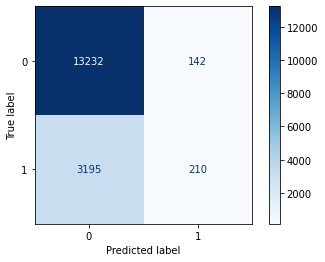

https://app.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-723
Validation
[0 0 0 ... 0 0 0] 

accuracy:  0.8060595065312046
recall:  0.06278434940855324
precision:  0.6388888888888888
f1:  0.1143330571665286
ROC AUC:  0.5269734119578456 

              precision    recall  f1-score   support

           0       0.81      0.99      0.89     13239
           1       0.64      0.06      0.11      3297

    accuracy                           0.81     16536
   macro avg       0.72      0.53      0.50     16536
weighted avg       0.78      0.81      0.74     16536



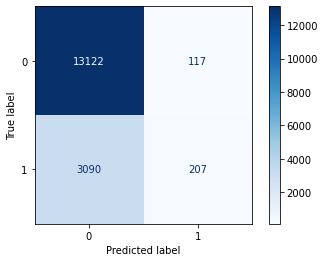

In [101]:
run_model(clf, train, test, validation, "EDA3", ["Raw", "final",'XGBClassifier', 'EDA3'])

https://app.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-724
Test
[0 0 0 ... 1 1 1] 

accuracy:  0.7857908476392995
recall:  0.8709437615614681
precision:  0.7442018494992171
f1:  0.8026000302699602
ROC AUC:  0.7857908476392995 

              precision    recall  f1-score   support

           0       0.84      0.70      0.77     57843
           1       0.74      0.87      0.80     57843

    accuracy                           0.79    115686
   macro avg       0.79      0.79      0.78    115686
weighted avg       0.79      0.79      0.78    115686



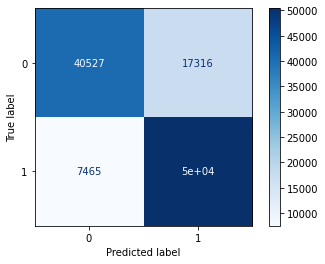

https://app.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-725
Validation
[1 1 1 ... 1 1 1] 

accuracy:  0.20343492985002418
recall:  0.9915074309978769
precision:  0.19917138853347957
f1:  0.3317097919837646
ROC AUC:  0.4993415997802286 

              precision    recall  f1-score   support

           0       0.77      0.01      0.01     13239
           1       0.20      0.99      0.33      3297

    accuracy                           0.20     16536
   macro avg       0.49      0.50      0.17     16536
weighted avg       0.66      0.20      0.08     16536



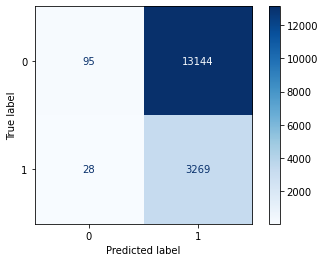

In [102]:
run_model(clf, smote_train, smote_test, validation, "EDA3", ["SMOTETomek", "final",'XGBClassifier', 'EDA3'])